# `axeap` Example

## Overview

`axeap` (Argonne X-ray Emission Analysis Package) is a python package used to analyze 2D images XES and produce spectra from them. This example notebook demonstrates the capabilities of `axeap`. The `axeap` package and an accompanying GUI that can be used to access its functionality without having to write code are both currently under development.

-----------

## Module Structure

`axeap` is composed of 4 submodules:
* `core`: All the essential code of the module
* `utils`: Helper functions that are not necessarily specific to x-ray science
* `experiment`: Used for performing live experiments.
* `inspect`: Used for displaying information.

In [1]:
import numpy as np
from pathlib import Path

import axeap
import axeap.core as core
import axeap.utils as utils
import axeap.experiment as experiment
import axeap.inspect as inspect
from axeap.core.conventions import X, Y

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
datapath = Path('/path/to/directory/containing/tiff/images/')

## Scans

A `Scan` object represent a single image loaded from the detector. One way to create a `Scan` is to load it from a TIFF image file. This will automatically set the name of the scan to be the filename. `Scan` is also a `DataItem`, so it is automatically assigned a UUID. 

In [4]:
s = core.Scan.loadFromPath(datapath/'NiO_Calib'/'Eiger_0003.tif')
s

Scan(name:Eiger_0003.tif,uuid:86085b2e-b3b4-4093-bd59-098fff30641d)

<IPython.core.display.Javascript object>


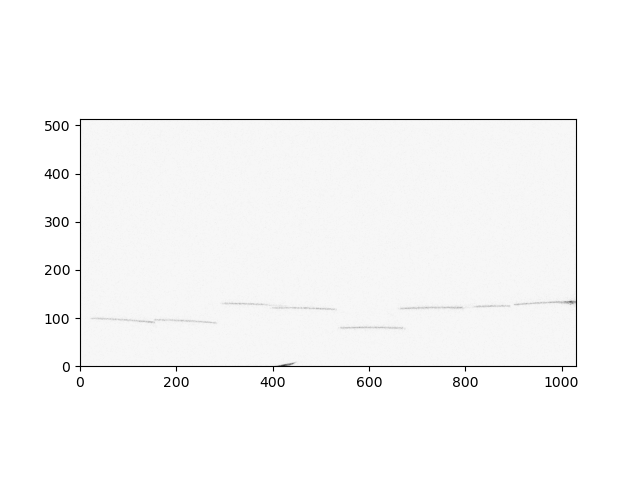

In [5]:
inspect.displayScan(s)

The actual image data can be retrieved using `Scan.getImg` and specifications can be passed in to modify the image. Any modified images are cached so they don't need to be calculated again. The will use a lot more space for a large number of images, but can speed things up greatly since `getImg` is called often.

In [6]:
i = s.getImg(cuts=(5,100))

The scan can also be modified with some specifications. This creates a new `Scan` that has a new default image specification (cuts, blur, etc). This allows a `Scan` to be passed to a function without that function needing to know the specifications previously made on the image.

In [7]:
modified_s = s.mod(cuts=(5,100))

In [8]:
(modified_s.getImg()==s.getImg(cuts=(5,100))).all()

True

## Calibration

We can start a calibration by loading a set of scans from a directory into a `ScanSet`, which is a subclass of `DataItemSet`. The point of using a `ScanSet` object rather than just a list is so that it can make sure that all the scans have the same dimensions and so that it can be used as a shared object that emits signals whenever scans are added or removed (more on the latter later).

In [9]:
calibscans = core.ScanSet.loadFromPath(datapath/'NiO_Calib')

In [10]:
calibscans.items

[Scan(name:Eiger_0001.tif,uuid:16ebaf6e-6cf1-4ffd-8774-6f4425b70694),
 Scan(name:Eiger_0002.tif,uuid:9e11ef4b-356d-470f-b6fc-0923b93ea0c9),
 Scan(name:Eiger_0003.tif,uuid:6a662d32-d3e0-4a19-8ec9-8275e7c2dc42),
 Scan(name:Eiger_0004.tif,uuid:b949b5d0-b606-40e8-94f4-80da68e89a39),
 Scan(name:Eiger_0005.tif,uuid:f0be09d3-4024-45bc-bf9e-a3fc4fa515ab),
 Scan(name:Eiger_0006.tif,uuid:e7e1ea4d-0933-42ad-9252-d5c46d97bc28),
 Scan(name:Eiger_0007.tif,uuid:42bf549c-e3c5-4995-b9c5-26c0ef0630b1),
 Scan(name:Eiger_0008.tif,uuid:52db3245-cfa2-4e4e-bb55-e8936d6fc0f2),
 Scan(name:Eiger_0009.tif,uuid:a6d93389-e368-47ad-83ec-1178319f1a53),
 Scan(name:Eiger_0010.tif,uuid:a406b398-4771-4423-a0e6-77b5b57f9c76),
 Scan(name:Eiger_0011.tif,uuid:158c7473-e00b-4117-94be-34bfdecba787),
 Scan(name:Eiger_0012.tif,uuid:9bd68c80-32ae-49ed-982d-580a195743f6),
 Scan(name:Eiger_0013.tif,uuid:f6fa74c1-0b47-4eb9-bc98-f9c02cc5d1a9),
 Scan(name:Eiger_0014.tif,uuid:35349d55-5d9d-40aa-a034-a11cfc7828e8),
 Scan(name:Eiger_001

Since a calibration run information file was included in the directory, the incident energy for each scan is put into the metadata properties.

In [11]:
calibscans.items[0].meta['IncidentEnergy']

8220.00455431

For the moment, let's ignore any scans that seems to have multiple vertical regions of interest. The method for calculating VROIs is explained more later.

In [12]:
validatedscans = [s for s in calibscans if len(core.calcVROIs(s.mod(cuts=(5,10)),20,20))==1]
calibscans = core.ScanSet(validatedscans)
calibscans.items

[Scan(name:Eiger_0001.tif,uuid:16ebaf6e-6cf1-4ffd-8774-6f4425b70694),
 Scan(name:Eiger_0002.tif,uuid:9e11ef4b-356d-470f-b6fc-0923b93ea0c9),
 Scan(name:Eiger_0003.tif,uuid:6a662d32-d3e0-4a19-8ec9-8275e7c2dc42),
 Scan(name:Eiger_0004.tif,uuid:b949b5d0-b606-40e8-94f4-80da68e89a39),
 Scan(name:Eiger_0005.tif,uuid:f0be09d3-4024-45bc-bf9e-a3fc4fa515ab),
 Scan(name:Eiger_0006.tif,uuid:e7e1ea4d-0933-42ad-9252-d5c46d97bc28),
 Scan(name:Eiger_0007.tif,uuid:42bf549c-e3c5-4995-b9c5-26c0ef0630b1),
 Scan(name:Eiger_0008.tif,uuid:52db3245-cfa2-4e4e-bb55-e8936d6fc0f2),
 Scan(name:Eiger_0009.tif,uuid:a6d93389-e368-47ad-83ec-1178319f1a53),
 Scan(name:Eiger_0010.tif,uuid:a406b398-4771-4423-a0e6-77b5b57f9c76),
 Scan(name:Eiger_0011.tif,uuid:158c7473-e00b-4117-94be-34bfdecba787),
 Scan(name:Eiger_0012.tif,uuid:9bd68c80-32ae-49ed-982d-580a195743f6),
 Scan(name:Eiger_0013.tif,uuid:f6fa74c1-0b47-4eb9-bc98-f9c02cc5d1a9),
 Scan(name:Eiger_0014.tif,uuid:35349d55-5d9d-40aa-a034-a11cfc7828e8),
 Scan(name:Eiger_001

Next we can use one of the scans to automatically determine horizontal regions of interest (HROIS) in the image. These HROIs (which are represented by objects of class `HROI` that subclass `ROI`) correspond to ranges of x values where the lines from the different crystals are. Note that if the signal from two crystals overlaps, they will only show up as one HROI.

We take a `Scan` from the `ScanSet` and use the `calcHROIs` function to find the HROIs. We specify the minimum width  the HROI to be a third of the maximum amount it reasonably could be (which is the entire span of the image divided by the number of crystals. We also specify that the HROIs be separated by a buffer of at least 10 pixels. The scan we pass in has cuts already applied (note the use of `Scan.mod`) to help the function find the lines since it uses a Fast Line Segement Detection (FLSD) algorithm. I am currently trying to figure out ways that this many parameters do not need to be specified.

In [13]:
s = calibscans.items[0]
numcrystals=8
min_width = s.dims[X]/numcrystals/3
hrois = core.calcHROIs(s.mod(cuts=(3,10)), min_width=min_width, group_buffer=10)
hrois

[HROI(x=31:150),
 HROI(x=160:285),
 HROI(x=298:383),
 HROI(x=401:529),
 HROI(x=544:665),
 HROI(x=675:794),
 HROI(x=824:1030)]

<IPython.core.display.Javascript object>


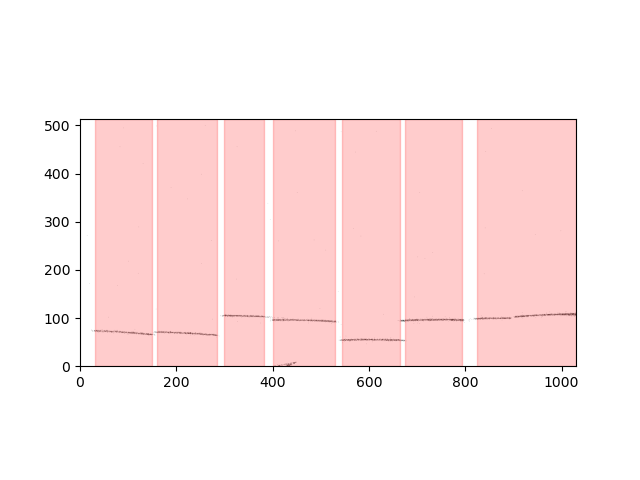

In [14]:
inspect.displayScan(s.mod(cuts=(3,10)),rois=hrois)

We can then pass these HROIs and the scanset to the `calcEMap` function in order to generate an `EnergyMap` object that represents a mapping of pixels in the 2D XES image to energies. `EnergyMap` can be saved and loaded from files. They are saved as ".npy" (numpy) files.

In [15]:
emap = core.calcEMap(calibscans, hrois)

In [16]:
emap.saveToPath('energymap.npy')

<IPython.core.display.Javascript object>


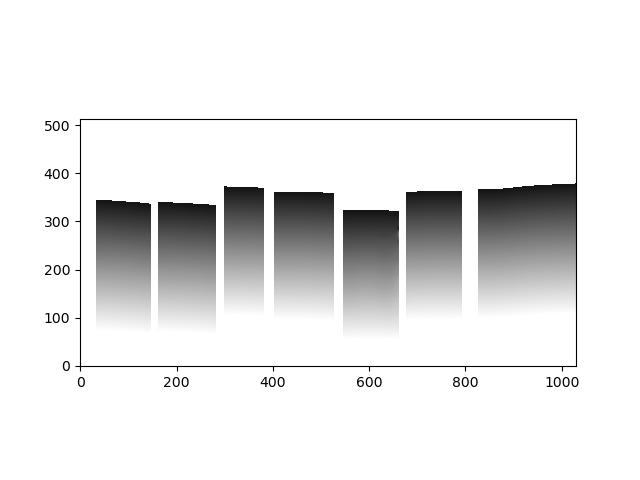

/tmp/ipykernel_948722/153046905.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(emap.values.swapaxes(0,1)),origin='lower',cmap='binary')


In [17]:
plt.figure()
plt.imshow(np.log(emap.values.swapaxes(0,1)),origin='lower',cmap='binary')

## (Further) ROI Detection

The HROIs for experimental images are best determined from the calibration images, but to find vertical ROIs (VROIs) we can use the `calcVROIs` function. For that we must first apply some lo/hi cuts to the image and specify that VROIs must be at least 20 pixels high and not have more than 20 pixel gaps (low intensity areas) within them.

In [18]:
s = core.Scan.loadFromPath(datapath/'NiO_XES'/'Eiger_0001.tif').mod(cuts=(5,10))
# Specify that VROIs must be 20px high, can't have more than 20px gaps
vrois = [core.calcVROIs(s.mod(roi=h), 20, 20, buffer=5)[0] for h in hrois]

In [19]:
vrois

[VROI(y=162:198),
 VROI(y=151:195),
 VROI(y=180:228),
 VROI(y=177:225),
 VROI(y=142:181),
 VROI(y=181:219),
 VROI(y=192:233)]

These `VROI` objects can be multiplied by the `HROI` objects to produce `RROI` (Rectangular ROI) objects.

In [20]:
rrois = [h*v for h,v in zip(hrois,vrois)]

<IPython.core.display.Javascript object>


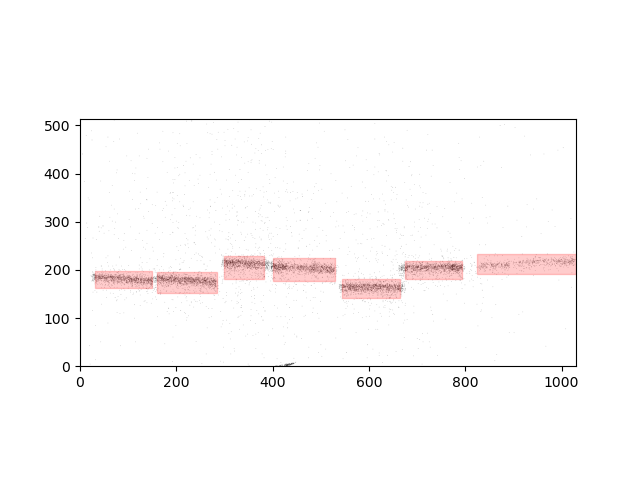

In [21]:
inspect.displayScan(s, rois=rrois)

Total intensity in `ROI`s can be counted.

In [22]:
print(s.count(rrois[1]))

6714.0


## Spectra Generation

We can generate spectra for whole scans or for specific ROIs.

<IPython.core.display.Javascript object>


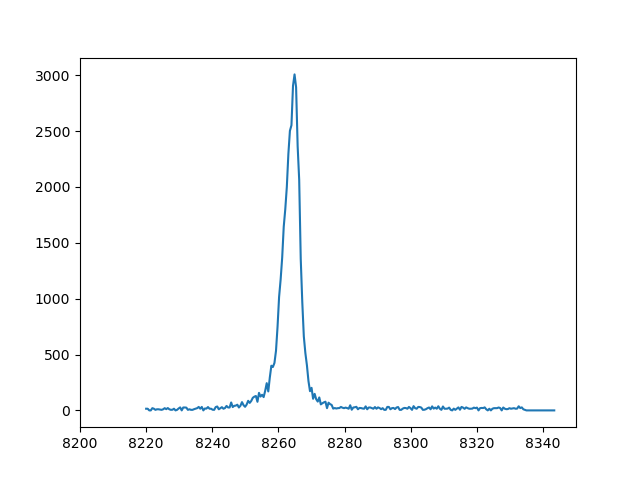

(8200.0, 8350.0)

In [23]:
inspect.displaySpectra(emap.calcSpectra(s))
plt.xlim(8200, 8350)

<IPython.core.display.Javascript object>


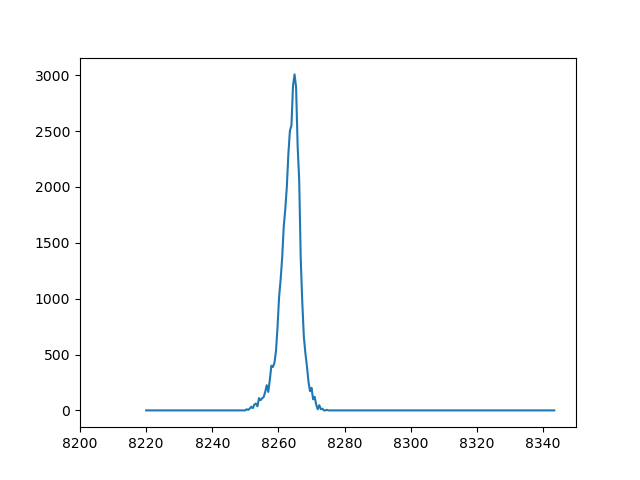

(8200.0, 8350.0)

In [24]:
inspect.displaySpectra(emap.calcSpectra(s.mod(roi=core.ComboROI(*rrois))))
plt.xlim(8200, 8350)

<IPython.core.display.Javascript object>


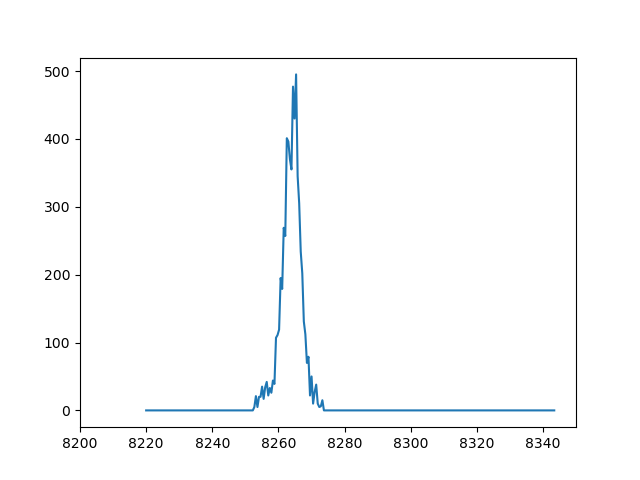

(8200.0, 8350.0)

In [25]:
inspect.displaySpectra(emap.calcSpectra(s.mod(roi=rrois[3])))
plt.xlim(8200, 8350)

With few points in a single ROI, the spectra is little jagged. It has not been smoothed.